The goal of this notebook will be to find regions that max/minimizes a criterion in an audio file.

For example we have a 1h conversation and we want to find what 20% of the data maximizes some heuristic based on the model output probabilities (e.g. lowest confidence).

In practice we would most likely want to perform this sampling for the whole dataset rather than filewise (i.e. find the aforementioned 20% in the whole dataset rather than find it for each individual file). But let's keep the scope smaller and make things easier for ourselves !

# Loading the data

In [1]:
PROTOCOL="MSDWILD.SpeakerDiarization.OriginalMany"
PROTOCOL_SUBSET='test'

First let's retrieve the data we previously generated into DataFrame `infdf` aswell as its associated metadata

In [2]:
import pandas as pd
from pathlib import Path
from powerset_calibration.inference import get_inference_fid, load_inference_file, load_inference_metadata, InferenceMetadata

fid = get_inference_fid('segmentation', PROTOCOL, PROTOCOL_SUBSET)
fid_path = Path('outputs')/fid

metadata: InferenceMetadata = load_inference_metadata(fid_path)
infdf: pd.DataFrame = load_inference_file(fid_path)

infdf

,uem,out_0,out_1,out_2,out_3,out_4,out_5,out_6,ref_0,ref_1,ref_2,ref_3,ref_4,ref_5,dataset,uri,ref_6,ref_7,ref_8,ref_9
0,True,0.009554,0.008599,0.749115,0.202438,0.002572,0.001593,0.026128,0.0,0.0,0.0,0.0,0.0,0.0,MSDWILD,00004,-1.0,-1.0,-1.0,-1.0
1,True,0.007836,0.007699,0.756682,0.201422,0.002065,0.001207,0.023090,0.0,0.0,0.0,0.0,0.0,0.0,MSDWILD,00004,-1.0,-1.0,-1.0,-1.0
2,True,0.007783,0.007697,0.760542,0.199639,0.001927,0.001188,0.021223,0.0,1.0,0.0,0.0,0.0,0.0,MSDWILD,00004,-1.0,-1.0,-1.0,-1.0
3,True,0.007709,0.007748,0.763758,0.199777,0.001693,0.001086,0.018230,0.0,1.0,0.0,0.0,0.0,0.0,MSDWILD,00004,-1.0,-1.0,-1.0,-1.0
4,True,0.007464,0.007655,0.767000,0.199589,0.001482,0.000994,0.015816,0.0,1.0,0.0,0.0,0.0,0.0,MSDWILD,00004,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687480,False,0.973313,0.002382,0.017132,0.006826,0.000092,0.000035,0.000219,0.0,0.0,0.0,0.0,0.0,-1.0,MSDWILD,03141,-1.0,-1.0,-1.0,-1.0
1687481,False,0.970997,0.002619,0.018684,0.007319,0.000103,0.000038,0.000242,0.0,0.0,0.0,0.0,0.0,-1.0,MSDWILD,03141,-1.0,-1.0,-1.0,-1.0
1687482,False,0.969682,0.002770,0.019347,0.007777,0.000114,0.000039,0.000270,0.0,0.0,0.0,0.0,0.0,-1.0,MSDWILD,03141,-1.0,-1.0,-1.0,-1.0
1687483,False,0.970696,0.002947,0.018097,0.007823,0.000125,0.000038,0.000273,0.0,0.0,0.0,0.0,0.0,-1.0,MSDWILD,03141,-1.0,-1.0,-1.0,-1.0


# Preparing the data

As a reminder, manually doing this stuff can be a bit hasardous, so for most uses I think it's easier to use `powerset_calibration.protocol.ActiveLearningProtocol` (or extend it/copy the code).

But let's do things manually here.
First let's convert our 'Inference Dataframe' data back to tensors. We will focus on one URI only.

In [3]:
from powerset_calibration.protocol import ActiveLearningProtocol
import torch

TREATED_URI = '03141' # set this to the URI you want to extract active learning windows on.

infdf2 = infdf[infdf.uri == TREATED_URI]

data = next(ActiveLearningProtocol.iterate_df_files(infdf2, metadata))

for k,v in data.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)
    else:
        print(k, v)

uri 03141
uem torch.Size([12, 589, 1])
ref torch.Size([12, 589, 5])
out torch.Size([12, 589, 7])


We can see that tensors are of shape `(windows_count, num_frames, x)`, which means the inference data is **unaggregated**, that is to say we still have *overlapping* data from applying a sliding window with overlap.

Pyannote inference (and the inference function from the first notebook) will aggregate things if they can be. But here we're dealing with the Speaker Diarization task, where any permutation of speaker identity is valid, meaning two classes might not mean the same things in two different outputs, so we cant aggregate them by just averaging their values (that's why there is an embedding extraction+clustering step in the pyannote pipeline).

Before we do this aggregation let's set up some information we need.

In [4]:
from pyannote.core import SlidingWindow
from pyannote.audio.utils.powerset import Powerset

model_fps = metadata["model"]["fps"]

model_sw = SlidingWindow(metadata["model"]["duration"], metadata["step_duration"])
"""This is the sliding window used to generate the inference file."""

model_frames = SlidingWindow(
    metadata["model"]["frames"]["duration"],
    metadata["model"]["frames"]["step"],
)
"""This precisely describes the alignment of the frames to the audio signal = receptive field"""

powerset = Powerset(
    len(metadata["model"]["specifications"]["classes"]),
    metadata["model"]["specifications"]["powerset_max_classes"],
)
"""Information about the model classes"""

'Information about the model classes'

Now we can aggregate `uem` (easy), aswell as `out` and `ref` (harder).

For prediction and reference, we ARE in (powerset) speaker diarization class space so we do have to use a smarter strategy. Here we rely on the 'SoftSegmentationPipeline' (using `aggregate_soft_segmentation`) which matches class spaces between windows using only their overlapped parts. It clearly couldn't be used for real diarization as their no notion of identity (persistence). But since we do not care about that (we want to retrieve model confidence/entropy/etc) it's all OK !

(and it doesn't need any embedding/clustering, so it's really cheap)


**Note**: Depending on the heuristic, we can actually "aggregate late". Here are the two ways to do aggregation (that we've thought of):
- **Early aggregation**: preds/ref *(W,F,C)*  --agg-->  preds/ref  *(F2,C)*  -->  heuristic  *(F2,)*
- **Late aggregation**: preds/ref *(W,F,C)* --> heuristic *(W,F,1)* --agg--> heuristics *(W,F,)*
The advantage of late aggregation is that we do not need any fancy aggregation strategy since we're already down to a tensor with 1 feature, so no ambiguity.

In [5]:
from powerset_calibration.utils.inference import aggregate_sliding_window_tensor, aggregate_soft_segmentation

# for UEM the aggregation doesnt exist as it only has one class (so we CAN just average the values, easy !)
uem = aggregate_sliding_window_tensor(
    tensor=data['uem'],
    sliding_window=model_sw,
    frames=model_frames,
)[...,0].bool()

pred = data['out']
ref = data['ref']

# Apply the soft segmentation-based aggregation
pred_agg = aggregate_soft_segmentation(
    t=data['out'],
    sliding_window=model_sw,
    powerset=powerset,
    frames=model_frames,
)
ref_agg = aggregate_soft_segmentation(
    t=data['ref'],
    sliding_window=model_sw,
    powerset=None,
    frames=model_frames,
)

uem.shape, pred_agg.shape, ref_agg.shape

(torch.Size([3829]), torch.Size([3829, 7]), torch.Size([3829, 5]))

Perfect, now we have tensors of size `(num_frames2, X)` that cover the whole file !

Now we have to decide what heuristic will be used to select high uncertainty region (or whatever we want to select). 

# Computing relevant regions

In [6]:
from powerset_calibration.utils.inference import get_heuristic_tensor_segmentation

# Just a shorthand to make things shorter
def get_heur(heurtype, preds):
    return get_heuristic_tensor_segmentation(
        heuristic=heurtype,
        preds=preds,
        targets=ref,
        sliding_window=model_sw,
        frames=model_frames,
        powerset=powerset,
    )

heur_rnd = get_heur('random', pred_agg)
heur_conf = get_heur('confidence', pred_agg)
heur_entropy = get_heur('entropy', pred_agg)

heur_conf_lateagg = get_heur('confidence', pred)
heur_entropy_lateagg = get_heur('entropy', pred)

heur_rnd.shape, heur_conf.shape, heur_entropy.shape, heur_conf_lateagg.shape, heur_entropy_lateagg.shape

(torch.Size([3829]),
 torch.Size([3829]),
 torch.Size([3829]),
 torch.Size([3829]),
 torch.Size([3829]))

Finally, let's find the relevant time regions according to our metrics.

In [7]:
from powerset_calibration.region_selector import generate_windows
import sys, math

SELECTED_REGIONS_MINSIZE = 5.0
REGION_SEARCH_STEP = 0.5
ANNOTATED_RATIO = 0.3

OVERLAP_PENALITY = None
REGIONS_PER_ITERATION = sys.maxsize

# Uncomment this to try disabling any possible overlap between regions (ie they will be strictly SELECTED_REGIONS_MINSIZE long)
# OVERLAP_PENALITY = math.inf
# REGIONS_PER_ITERATION = 1

def gen_wins(heur):
    return generate_windows(
        values=heur,
        fps=model_fps,
        window_duration=SELECTED_REGIONS_MINSIZE,
        sliding_window_step=REGION_SEARCH_STEP,
        annotated_ratio=ANNOTATED_RATIO,
        penality=OVERLAP_PENALITY,
        selections_per_iteration=REGIONS_PER_ITERATION,
        uem=uem,
    )

selected_rnd = gen_wins(heur_rnd)
selected_conf = gen_wins(heur_conf)
selected_entropy = gen_wins(heur_entropy)
selected_conf_lateagg = gen_wins(heur_conf_lateagg)
selected_entropy_lateagg = gen_wins(heur_entropy_lateagg)


Now we can visualize everything !
For 'selected from X', the first line is the value of the heuristic at each point in time, and the second line shows the region that it ended up selecting.

You can edit the parameter in the previous block to see different results.

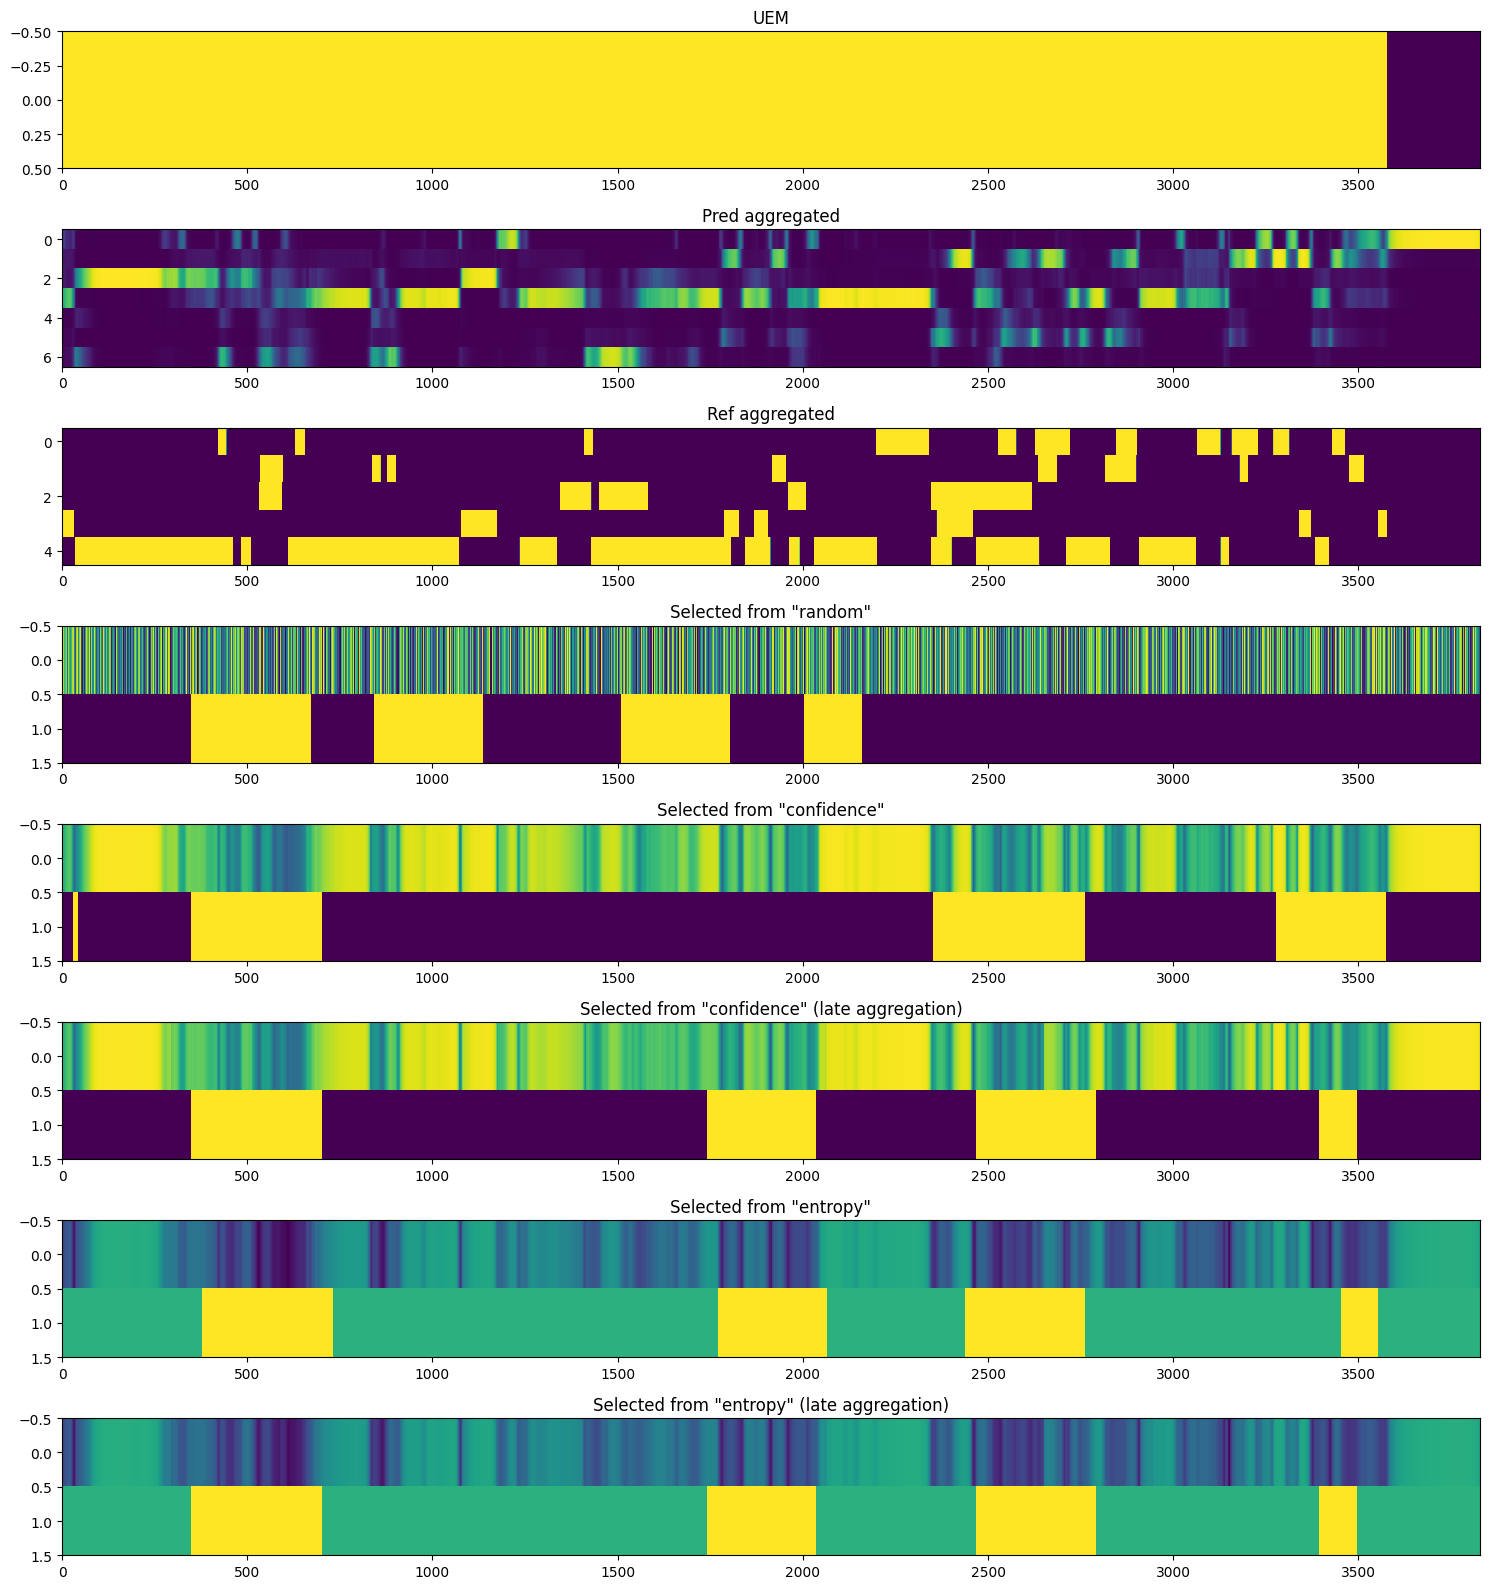

In [8]:
import matplotlib.pyplot as plt

def plot_tensor(ax, t,  title=None):
    if isinstance(t, list):
        t = [t2.squeeze()[...,None] for t2 in t]
        t = torch.cat(t, dim=1)
    ax.imshow(t.T, aspect='auto', interpolation='nearest')
    ax.set_title(title)

nrows = 8
fig, axs = plt.subplots(nrows, 1, figsize=(15, nrows*2))
plot_tensor(axs[0], uem[...,None], title='UEM')
plot_tensor(axs[1], pred_agg, title='Pred aggregated')
plot_tensor(axs[2], ref_agg, title='Ref aggregated')
plot_tensor(axs[3], [heur_rnd, selected_rnd], title='Selected from "random"')
plot_tensor(axs[4], [heur_conf, selected_conf], title='Selected from "confidence"')
plot_tensor(axs[5], [heur_conf_lateagg, selected_conf_lateagg], title='Selected from "confidence" (late aggregation)')
plot_tensor(axs[6], [heur_entropy, selected_entropy], title='Selected from "entropy"')
plot_tensor(axs[7], [heur_entropy_lateagg, selected_entropy_lateagg], title='Selected from "entropy" (late aggregation)')


fig.tight_layout()


And conversion from Tensor to Timeline is straightforward

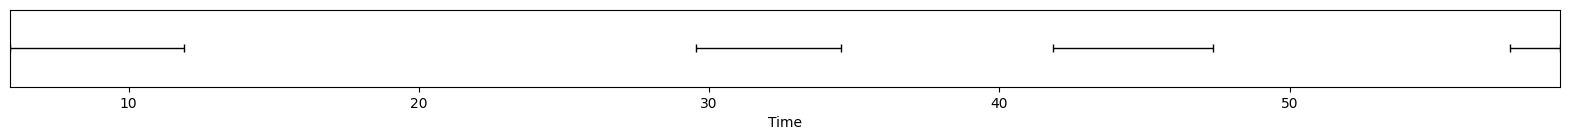

In [10]:
from powerset_calibration.utils.pyannote_core import tensor_to_timeline

selected_entropy_lateagg_tl = tensor_to_timeline(selected_entropy_lateagg, model_fps)
selected_entropy_lateagg_tl